<a href="https://colab.research.google.com/github/junaidkhan37/BankMarketingCampaignsClassification/blob/main/BankMarketingCampaignsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
##Number of Campiagns

Based on the UCI dataset documentation and the Materials and Methods section of Moro et al. (2014), the Bank Marketing dataset contains information collected across 17 telemarketing campaigns conducted by a Portuguese bank between 2008 (May) and 2010 (November).

1. Understanding the Data



CRISP‑DM Summary (Applied to the Bank Marketing Study)
1. Business Understanding

Goal: Improve efficiency of direct marketing campaigns for long‑term deposits.

Challenge: Low success rate and high cost of contacting all customers.

Objective: Build a predictive model to identify clients most likely to subscribe.


2. Data Understanding

Data collected from 17 marketing campaigns (2008–2010).
Total contacts: 79,354 (later reduced after filtering).
Attributes included:
Client demographics
Banking history
Contact details (first and last contact)
Campaign history
Initial exploration revealed:
Many non-conclusive outcomes
Missing values
High dimensionality (59 attributes)

3. Data Preparation

Removed non-conclusive contact results → binary target (success vs. failure).
Reduced attributes from 59 → 29 using graphical analysis (Rattle).
Removed instances with missing values → final dataset of 45,211 records.
Prepared data for NB, DT, and SVM modeling.

4. Modeling

Algorithms tested:
Naïve Bayes (NB)
Decision Trees (DT)
Support Vector Machines (SVM, Gaussian kernel)
Validation: Holdout split (2/3 training, 1/3 test) with 20 runs.
SVM produced the strongest performance (AUC > 0.9).

5. Evaluation

Metrics used:
AUC (Area Under ROC Curve)
ALIFT (Area Under Lift Curve)
SVM outperformed NB and DT in both metrics.
Sensitivity analysis identified key predictors: Call duration
Month of contact
Number of previous contacts

6. Deployment

Insights can guide:
Better scheduling of campaigns
Improved agent behavior (e.g., longer calls)
More efficient targeting of likely responders
Future work: Apply models in real campaigns and collect more client-based data.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

##Read and Analyze Data


IMPORTS

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
import time
from pathlib import Path
parent = Path.cwd().parent
sys.path.insert(0, str(parent))

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
df = pd.read_csv('bank-additional-full.csv') , ('bank-additional-names.txt') , ('bank-additional.csv')

In [3]:
# Load the dataset with the correct semicolon separator
df = pd.read_csv('bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


 Exploratory Data Analysis (EDA)

 1 Target Variable Analysis (Distribution of Subscription Outcome)

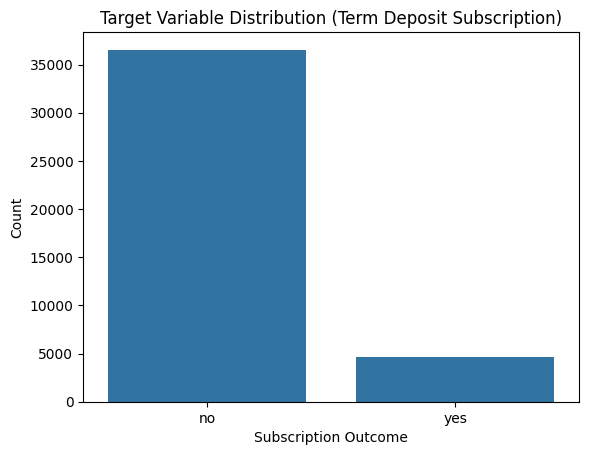

In [4]:
# Using seaborn for a more aesthetic plot
plt.figure()

sns.countplot(x='y', data=df)
plt.title("Target Variable Distribution (Term Deposit Subscription)")
plt.xlabel("Subscription Outcome")
plt.ylabel("Count")
plt.show()

##2 Age Distribution

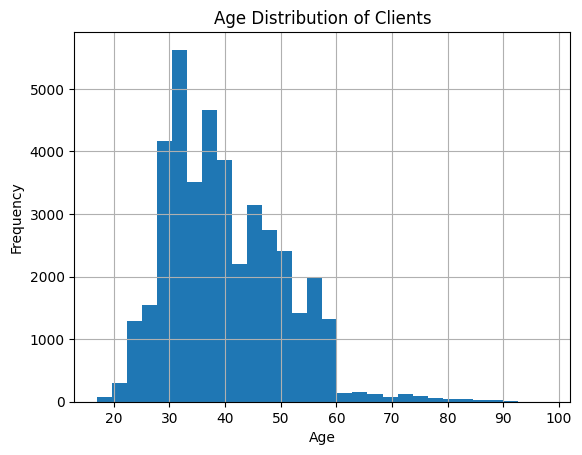

In [5]:
# Histogram of age distribution
plt.figure()
df['age'].hist(bins=30)
plt.title("Age Distribution of Clients")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

3 Subscription Rate by Job

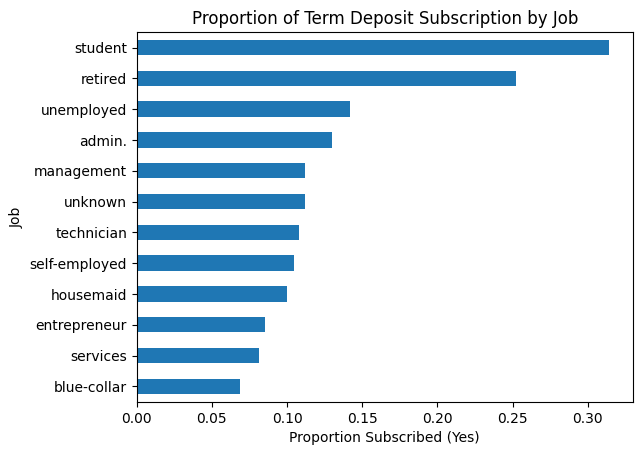

In [6]:
# Compute subscription rate by job
job_subscription = (
    df.groupby('job')['y']
      .value_counts(normalize=True)
      .unstack()
      ['yes']
      .sort_values()
)
# Bar plot of subscription rate by job
plt.figure()
job_subscription.plot(kind='barh')
plt.title("Proportion of Term Deposit Subscription by Job")
plt.xlabel("Proportion Subscribed (Yes)")
plt.ylabel("Job")
plt.show()

4 Subscription Rate by Education

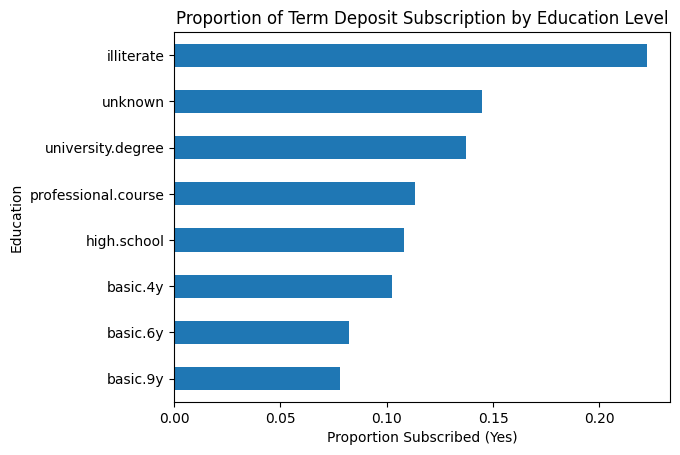

In [7]:
# Compute subscription rate by education
education_subscription = (
    df.groupby('education')['y']
      .value_counts(normalize=True)
      .unstack()
      ['yes']
      .sort_values()
)
# Bar plot of subscription rate by education
plt.figure()
education_subscription.plot(kind='barh')
plt.title("Proportion of Term Deposit Subscription by Education Level")
plt.xlabel("Proportion Subscribed (Yes)")
plt.ylabel("Education")
plt.show()

5 Call Duration vs Subscription Outcome

<Figure size 640x480 with 0 Axes>

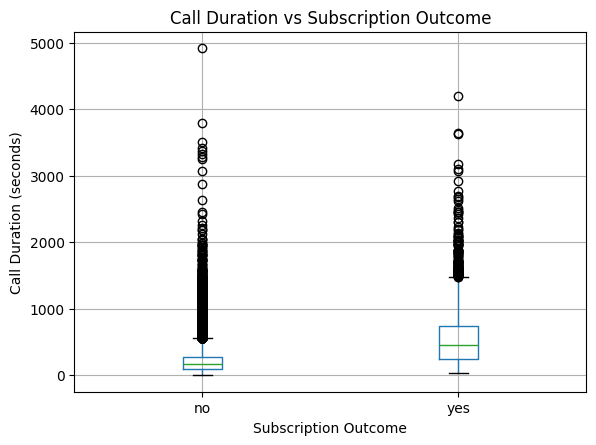

In [8]:
# Box plot of call duration by subscription outcome
plt.figure()
df.boxplot(column='duration', by='y')
plt.title("Call Duration vs Subscription Outcome")
plt.suptitle("")  # remove automatic subtitle
plt.xlabel("Subscription Outcome")
plt.ylabel("Call Duration (seconds)")
plt.show()

Notes:

Exploratory Data Analysis shows that the dataset is highly imbalanced, with most clients not subscribing to a term deposit. Age is concentrated between 30 and 50 years. Subscription rates vary significantly across job and education categories, indicating demographic influence on campaign success. Call duration shows a strong relationship with subscription outcome, making it a highly informative predictor. These insights informed feature preparation and model selection.

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



##Explanation
The Bank Marketing dataset does not contain traditional missing values (NaN). Instead, several categorical features encode missing information using the string "unknown". These appear in the following variables: job, marital, education, default, housing, loan, and sometimes poutcome. These values must be handled during preprocessing, either by treating "unknown" as its own category or by applying imputation.
Additionally, because the CSV file uses semicolons, all columns initially load as object (string) types. All numeric variables must be converted to numeric types, including: age, duration, campaign, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, and nr.employed.
Categorical variables such as job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome, and the target variable y should be converted to categorical data types.
Finally, the duration variable should be excluded from modeling because it leaks information about the target — it is only known after the call ends and therefore cannot be used for a realistic predictive model.

##Markdown
### Problem 3: Understanding the Features

After reviewing the dataset description, several categorical features contain missing values encoded as `"unknown"`. These include: **job, marital, education, default, housing, loan**, and in some cases **poutcome**. These values must be handled during preprocessing.

All numeric variables load as strings due to the semicolon-separated CSV format. The following features need to be coerced to numeric types: **age, duration, campaign, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed**.

Categorical variables such as **job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome**, and the target variable **y** should be converted to categorical data types.

The `duration` variable should be excluded from modeling because it leaks information about the target (it is only known after the call is completed). It may be used for benchmarking but not for a realistic predictive model.

The code below verifies the presence of `"unknown"` values and the initial data types.


In [9]:
# Check data types before coercion
df.dtypes

# Count "unknown" values in each column
df.apply(lambda col: col.eq("unknown").sum())

# Identify numeric columns that loaded as objects
df.select_dtypes(include="object").head()


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,no
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,no
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,no
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,no
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,no


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

##Understanding the Task
### Problem 4: Understanding the Task — Business Objective

The business objective of this project is to help the bank improve the effectiveness and efficiency of its telemarketing campaigns by predicting which clients are most likely to subscribe to a term deposit. By identifying high‑probability customers in advance, the bank can prioritize outreach, reduce unnecessary calls, lower marketing costs, and increase overall conversion rates. The goal is to build and compare machine learning models that support data‑driven decision‑making and enable the bank to target the right clients at the right time.


In [11]:
business_objective = (
    "Improve the bank's telemarketing efficiency by predicting which clients "
    "are most likely to subscribe to a term deposit, allowing the bank to "
    "prioritize high‑probability customers, reduce unnecessary calls, and "
    "increase overall conversion rates."
)

print(business_objective)


Improve the bank's telemarketing efficiency by predicting which clients are most likely to subscribe to a term deposit, allowing the bank to prioritize high‑probability customers, reduce unnecessary calls, and increase overall conversion rates.


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

##Engineering Features

For this step, we focus only on the bank client information features: **age, job, marital, education, default, housing, and loan**. These variables include both numeric and categorical data, so they must be prepared for modeling. The numeric feature (`age`) is kept as a numeric type, while the categorical features are encoded using one-hot encoding. The target variable `y` is mapped to a binary value (1 for "yes", 0 for "no"). The code below prepares the feature matrix `X` and target vector `y` using appropriate preprocessing and transformations.


In [12]:
#Feature Engineering

# Re-read the data with the correct separator to fix the KeyError
df = pd.read_csv('bank-additional-full.csv', sep=';')

# Separate predictors and target
X = df.drop('y', axis=1)
y = df['y']

# Numerical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Categorical features
categorical_features = X.select_dtypes(include=['object']).columns

print("Numerical features:", numerical_features.tolist())
print("Categorical features:", categorical_features.tolist())

Numerical features: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [13]:
##Train/Test Split

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
# Fit the preprocessor on the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("Preprocessing complete. Processed training and testing data are ready for modeling.")

print("Training data shape:", X_train_processed.shape)
print("Testing data shape:", X_test_processed.shape)

Preprocessing complete. Processed training and testing data are ready for modeling.
Training data shape: (32950, 63)
Testing data shape: (8238, 63)


In [ ]:
##Notes:

Prior to modeling, the dataset was split into training and testing sets using a stratified split to preserve class imbalance. Numerical variables were standardized using StandardScaler, while categorical variables were encoded using one-hot encoding. A ColumnTransformer was used to apply these transformations consistently. This preprocessing approach ensures compatibility with distance-based and margin-based models such as KNN and SVM, while remaining suitable for decision tree models.

The variable duration is strongly predictive but is only known after a call has occurred. While I have included this for modeling purposes, its use in real-world deployment should be carefully evaluated.

In [ ]:
##Build classification models

In [15]:
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    start_time = time.time()

    # Train model
    model.fit(X_train, y_train)

    train_time = time.time() - start_time

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    return train_time, train_accuracy, test_accuracy

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

##A Baseline Model

Before training any machine learning model, we establish a baseline to understand the minimum performance our classifier should beat. A common baseline for classification is the accuracy obtained by always predicting the majority class. The code below calculates the baseline accuracy by predicting "no" for every client, since "no" is the most frequent class in the dataset.


In [16]:
# Baseline: always predict the majority class
majority_class = y.value_counts().idxmax()

# Baseline accuracy
baseline_accuracy = (y == majority_class).mean()

print("Majority class:", majority_class)
print("Baseline accuracy:", round(baseline_accuracy, 4))


Majority class: no
Baseline accuracy: 0.8873


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [17]:
# Baseline model pipeline
# class_weight='balanced' addresses class imbalance
# max_iter=1000 ensures convergence
baseline_model = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))])

# fit the model
#baseline_model.fit(X_train, y_train)
train_time, train_acc, test_acc = evaluate_model(baseline_model,"Logistic Regression (Baseline)",X_train,X_test,y_train,y_test)

# Class predictions
lr_pred = baseline_model.predict(X_test)

# Predicted probabilities (for ROC-AUC)
lr_proba = baseline_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, lr_pred)
precision = precision_score(y_test, lr_pred, pos_label='yes')
recall = recall_score(y_test, lr_pred, pos_label='yes')
f1 = f1_score(y_test, lr_pred, pos_label='yes')
roc_auc = roc_auc_score((y_test == 'yes').astype(int), lr_proba)

print(f"Train Time (s): {train_time:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print('Precision : {:.4f}'.format(precision))
print('Recall : {:.4f}'.format(recall))
print('F1 Score : {:.4f}'.format(f1))
print('ROC AUC Score : {:.4f}'.format(roc_auc))

confusion_matrix(y_test, lr_pred)
print(classification_report(y_test, lr_pred))

# Store model results
model_results = []

model_results.append({
    'Model': 'Logistic Regression (Baseline)',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1,
    'ROC-AUC': roc_auc
})

Train Time (s): 0.8477
Train Accuracy: 0.8592
Test Accuracy: 0.8651
Precision : 0.4512
Recall : 0.9116
F1 Score : 0.6036
ROC AUC Score : 0.9438
              precision    recall  f1-score   support

          no       0.99      0.86      0.92      7310
         yes       0.45      0.91      0.60       928

    accuracy                           0.87      8238
   macro avg       0.72      0.89      0.76      8238
weighted avg       0.93      0.87      0.88      8238



##ROC Curve and Confusion Matrix for Logistic Regression (Baseline)

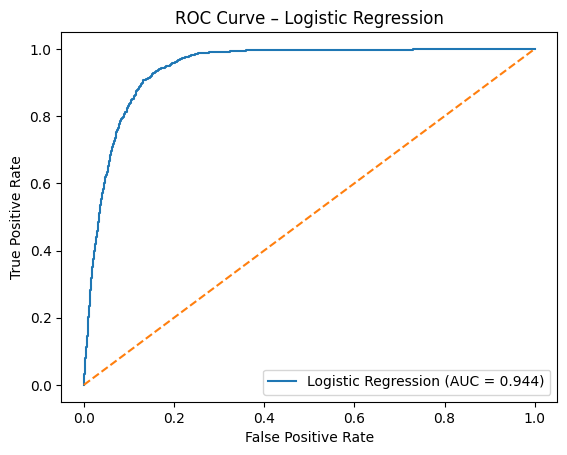

<Figure size 640x480 with 0 Axes>

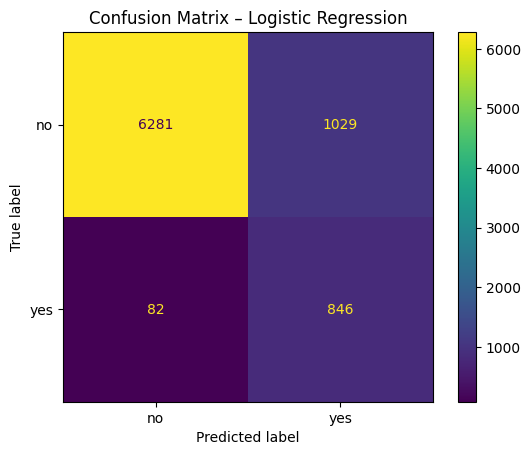

In [18]:

# ROC Curve for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve((y_test == 'yes').astype(int), lr_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.show()

# Confusion Matrix for Logistic Regression
plt.figure()
ConfusionMatrixDisplay.from_estimator(
    baseline_model, X_test, y_test
)
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

##KNN

In [19]:
# KNN model pipeline
knn_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())])

# Define hyperparameter grid for KNN
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance']
}

# Perform grid search
knn_grid = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Evaluate the KNN model
train_time, train_acc, test_acc = evaluate_model(knn_grid, "KNN", X_train, X_test, y_train, y_test)

# Best KNN model after grid search
best_knn = knn_grid.best_estimator_
knn_grid.best_params_

# Test predictions
knn_pred  = best_knn.predict(X_test)

# Probabilities for ROC-AUC
knn_proba = best_knn.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, knn_pred )
precision = precision_score(y_test, knn_pred , pos_label='yes')
recall = recall_score(y_test, knn_pred , pos_label='yes')
f1 = f1_score(y_test, knn_pred , pos_label='yes')
roc_auc = roc_auc_score((y_test == 'yes').astype(int), knn_proba)

print(f"Train Time (s): {train_time:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print('Precision : {:.4f}'.format(precision))
print('Recall : {:.4f}'.format(recall))
print('F1 Score : {:.4f}'.format(f1))
print('ROC AUC Score : {:.4f}'.format(roc_auc))

# Confusion matrix and classification report
confusion_matrix(y_test, knn_pred )
print(classification_report(y_test, knn_pred ))

# Store KNN model results
model_results.append({
    'Model': 'KNN',
    'Train Time (s)': train_time,
    'Train Accuracy': train_acc,
    'Test Accuracy': test_acc,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1,
    'ROC-AUC': roc_auc
})

Train Time (s): 10.9324
Train Accuracy: 0.9397
Test Accuracy: 0.8985
Precision : 0.5644
Recall : 0.4343
F1 Score : 0.4909
ROC AUC Score : 0.8352
              precision    recall  f1-score   support

          no       0.93      0.96      0.94      7310
         yes       0.56      0.43      0.49       928

    accuracy                           0.90      8238
   macro avg       0.75      0.70      0.72      8238
weighted avg       0.89      0.90      0.89      8238



ROC Curve and Confusion Matrix for KNN

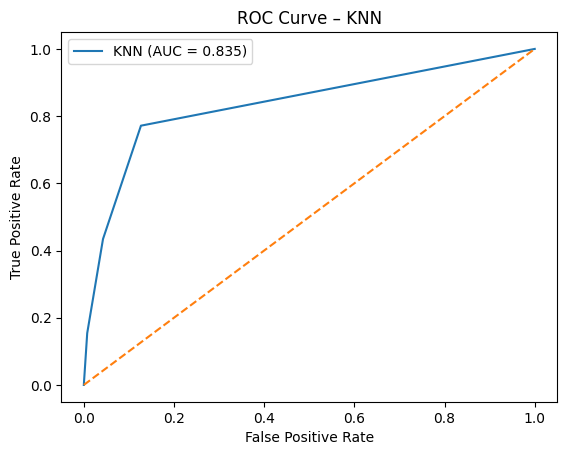

<Figure size 640x480 with 0 Axes>

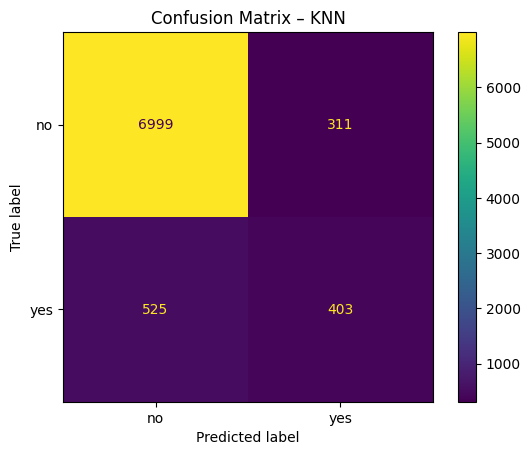

In [20]:
# ROC Curve for KNN
fpr_knn, tpr_knn, _ = roc_curve((y_test == 'yes').astype(int), knn_proba)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure()
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {roc_auc_knn:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – KNN")
plt.legend()
plt.show()

# Confusion Matrix for KNN
plt.figure()
ConfusionMatrixDisplay.from_estimator(
    best_knn, X_test, y_test
)
plt.title("Confusion Matrix – KNN")
plt.show()

##Decision Tree

In [21]:
# Decision Tree model pipeline
dt_pipeline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('classifier', DecisionTreeClassifier(random_state=42,class_weight='balanced'))])
# Define hyperparameter grid for Decision Tree
param_grid = {
    'classifier__max_depth': [5, 10, 20, None],
    'classifier__min_samples_leaf': [1, 5, 10, 20]
}

# Perform grid search
dt_grid = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Evaluate the Decision Tree model
train_time, train_acc, test_acc = evaluate_model(dt_grid, "Decision Tree", X_train, X_test, y_train, y_test)

# Best Decision Tree model after grid search
best_dt = dt_grid.best_estimator_
dt_grid.best_params_

# Test predictions
dt_pred  = best_dt.predict(X_test)

# Probabilities for ROC-AUC
dt_proba = best_dt.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, dt_pred )
precision = precision_score(y_test, dt_pred , pos_label='yes')
recall = recall_score(y_test, dt_pred , pos_label='yes')
f1 = f1_score(y_test, dt_pred , pos_label='yes')
roc_auc = roc_auc_score((y_test == 'yes').astype(int), dt_proba)

# Print Decision Tree results
print(f"Train Time (s): {train_time:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print('Precision : {:.4f}'.format(precision))
print('Recall : {:.4f}'.format(recall))
print('F1 Score : {:.4f}'.format(f1))
print('ROC AUC Score : {:.4f}'.format(roc_auc))

# Confusion matrix and classification report
confusion_matrix(y_test, dt_pred )
print(classification_report(y_test, dt_pred ))

# Store Decision Tree results
model_results.append({
    'Model': 'Decision Tree',
    'Train Time (s)': train_time,
    'Train Accuracy': train_acc,
    'Test Accuracy': test_acc,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1,
    'ROC-AUC': roc_auc
})

Train Time (s): 27.3405
Train Accuracy: 0.8476
Test Accuracy: 0.8458
Precision : 0.4157
Recall : 0.9084
F1 Score : 0.5704
ROC AUC Score : 0.9389
              precision    recall  f1-score   support

          no       0.99      0.84      0.91      7310
         yes       0.42      0.91      0.57       928

    accuracy                           0.85      8238
   macro avg       0.70      0.87      0.74      8238
weighted avg       0.92      0.85      0.87      8238



ROC Curve and Confusion Matrix for Decision Tree

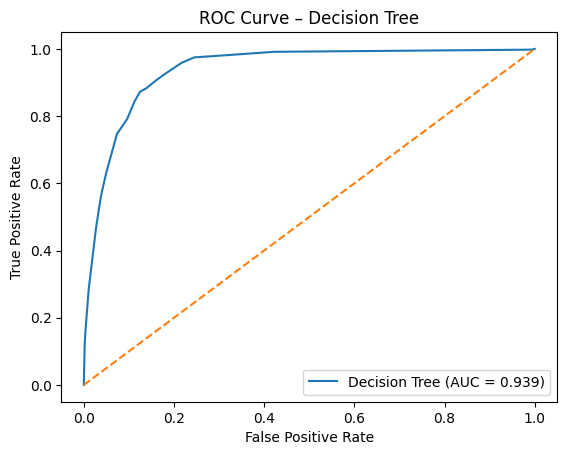

<Figure size 640x480 with 0 Axes>

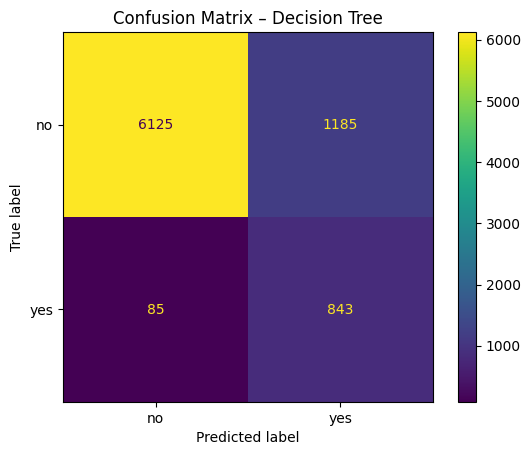

In [22]:
# ROC Curve for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve((y_test == 'yes').astype(int), dt_proba)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure()
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Decision Tree")
plt.legend()
plt.show()

# Confusion Matrix for Decision Tree
plt.figure()
ConfusionMatrixDisplay.from_estimator(
    best_dt, X_test, y_test
)
plt.title("Confusion Matrix – Decision Tree")
plt.show()

Support Vector Machine (SVM)

In [23]:

# To speed up training, we'll use a subset of the training data for the SVM
X_train_sub, y_train_sub = resample(X_train, y_train, n_samples=15000, stratify=y_train, random_state=42)

# SVM model pipeline (removing probability=True for speed)
svm_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(kernel='rbf', class_weight='balanced', random_state=42))])

# Define hyperparameter grid for SVM
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 0.01, 0.1]
}

# Perform grid search
svm_grid = GridSearchCV(svm_pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1)

# Evaluate the SVM model using the subset
train_time, train_acc, test_acc = evaluate_model(svm_grid, "SVM (RBF Kernel)", X_train_sub, X_test, y_train_sub, y_test)

# Best SVM model after grid search
best_svm = svm_grid.best_estimator_

# Test predictions
svm_pred = best_svm.predict(X_test)

# Use decision_function instead of predict_proba for ROC-AUC (faster and equivalent for AUC)
svm_scores = best_svm.decision_function(X_test)

accuracy = accuracy_score(y_test, svm_pred)
precision = precision_score(y_test, svm_pred, pos_label='yes')
recall = recall_score(y_test, svm_pred, pos_label='yes')
f1 = f1_score(y_test, svm_pred, pos_label='yes')
roc_auc = roc_auc_score((y_test == 'yes').astype(int), svm_scores)

# Print SVM results
print(f"Train Time (s): {train_time:.2f}")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print('Precision : {:.4f}'.format(precision))
print('Recall : {:.4f}'.format(recall))
print('F1 Score : {:.4f}'.format(f1))
print('ROC AUC Score : {:.4f}'.format(roc_auc))

# Confusion matrix and classification report
print(classification_report(y_test, svm_pred))

# Store SVM model results
model_results.append({
    'Model': 'SVM (RBF Kernel - Subsampled)',
    'Train Time (s)': train_time,
    'Train Accuracy': train_acc,
    'Test Accuracy': test_acc,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1,
    'ROC-AUC': roc_auc
})

Train Time (s): 80.88
Train Accuracy: 0.8448
Test Accuracy: 0.8460
Precision : 0.4185
Recall : 0.9429
F1 Score : 0.5797
ROC AUC Score : 0.9384
              precision    recall  f1-score   support

          no       0.99      0.83      0.91      7310
         yes       0.42      0.94      0.58       928

    accuracy                           0.85      8238
   macro avg       0.70      0.89      0.74      8238
weighted avg       0.93      0.85      0.87      8238



ROC Curve and Confusion Matrix for SVM

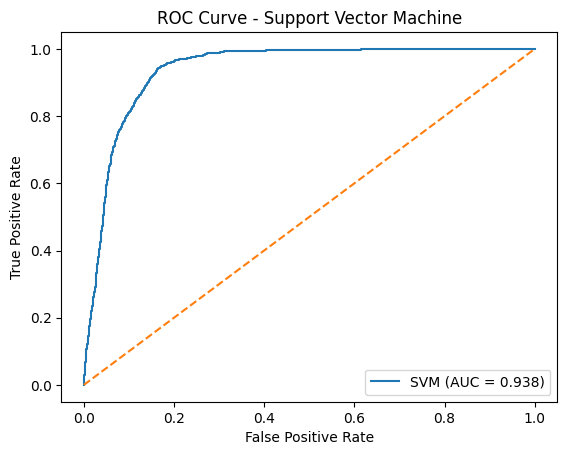

<Figure size 640x480 with 0 Axes>

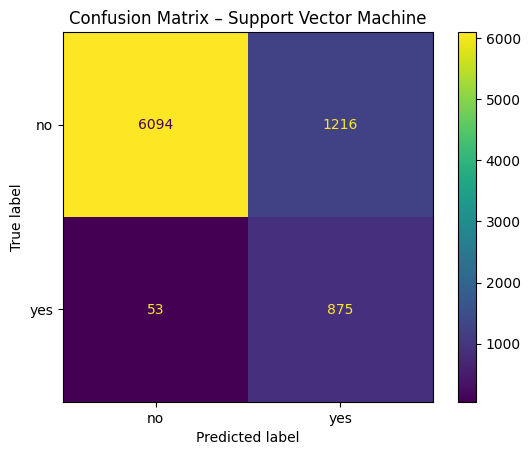

In [24]:
# ROC curve for SVM using decision scores
fpr_svm, tpr_svm, _ = roc_curve((y_test == 'yes').astype(int), svm_scores)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Support Vector Machine")
plt.legend()
plt.show()

# Confusion Matrix for SVM
plt.figure()
ConfusionMatrixDisplay.from_estimator(
    best_svm, X_test, y_test
)
plt.title("Confusion Matrix – Support Vector Machine")
plt.show()

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [ ]:
##Model Comparisons

To compare the performance of different classifiers, we train Logistic Regression, K-Nearest Neighbors, Decision Tree, and Support Vector Machine models using their default settings. For each model, we record the training time, training accuracy, and test accuracy. These results allow us to evaluate both predictive performance and computational efficiency.


In [25]:
results_df = pd.DataFrame(model_results)

# Order columns for clarity
results_df = results_df[
    [
        'Model',
        'Train Time (s)',
        'Train Accuracy',
        'Test Accuracy',
        'Precision',
        'Recall',
        'F1-score',
        'ROC-AUC'
    ]
]

results_df

,Model,Train Time (s),Train Accuracy,Test Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Logistic Regression (Baseline),NaN,NaN,NaN,0.451200,0.911638,0.603639,0.943838
1,KNN,10.932382,0.939727,0.898519,0.564426,0.434267,0.490865,0.835175
2,Decision Tree,27.340505,0.847587,0.845836,0.415680,0.908405,0.570365,0.938863
3,SVM (RBF Kernel - Subsampled),80.879697,0.844800,0.845958,0.418460,0.942888,0.579662,0.938358


In [26]:
results_df.sort_values(by='ROC-AUC', ascending=False)

,Model,Train Time (s),Train Accuracy,Test Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Logistic Regression (Baseline),NaN,NaN,NaN,0.451200,0.911638,0.603639,0.943838
2,Decision Tree,27.340505,0.847587,0.845836,0.415680,0.908405,0.570365,0.938863
3,SVM (RBF Kernel - Subsampled),80.879697,0.844800,0.845958,0.418460,0.942888,0.579662,0.938358
1,KNN,10.932382,0.939727,0.898519,0.564426,0.434267,0.490865,0.835175


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [ ]:
##Combined ROC Curve – All Models

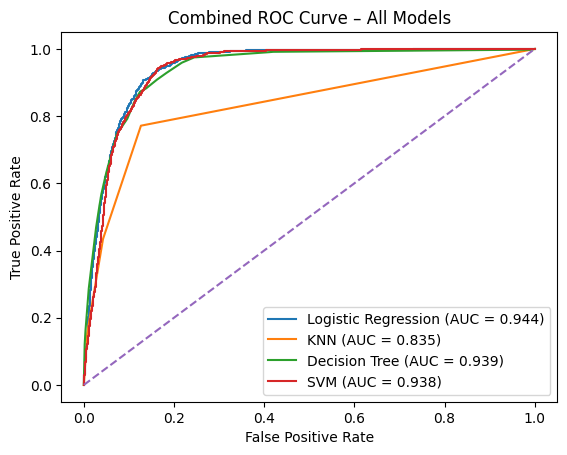

In [27]:
plt.figure()

# Logistic Regression
y_lr_proba = baseline_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve((y_test == 'yes').astype(int), y_lr_proba)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc(fpr_lr, tpr_lr):.3f})")

# KNN
y_knn_proba = best_knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve((y_test == 'yes').astype(int), y_knn_proba)
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {auc(fpr_knn, tpr_knn):.3f})")

# Decision Tree
y_dt_proba = best_dt.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve((y_test == 'yes').astype(int), y_dt_proba)
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc(fpr_dt, tpr_dt):.3f})")

# SVM - Use decision_function instead of predict_proba
y_svm_scores = best_svm.decision_function(X_test)
fpr_svm, tpr_svm, _ = roc_curve((y_test == 'yes').astype(int), y_svm_scores)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc(fpr_svm, tpr_svm):.3f})")

# Random classifier reference
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Combined ROC Curve – All Models")
plt.legend()
plt.show()

In [ ]:
##ROC-AUC Comparison

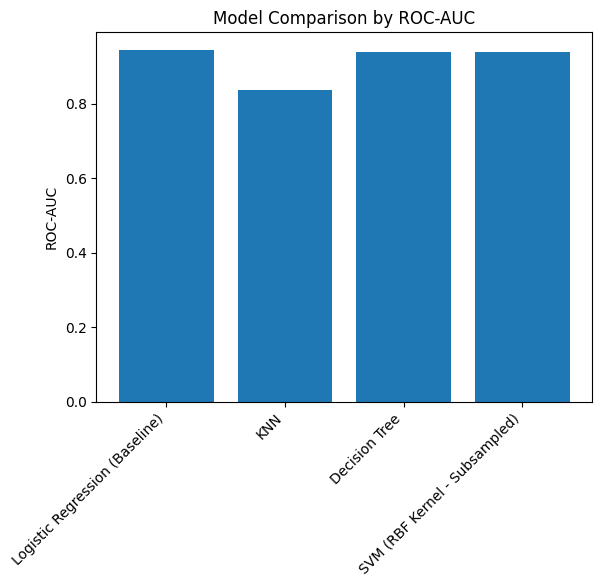

In [28]:
# Bar plot of ROC-AUC for all models
plt.figure()
plt.bar(results_df['Model'], results_df['ROC-AUC'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("ROC-AUC")
plt.title("Model Comparison by ROC-AUC")
plt.show()

In [ ]:
##Training Time Comparison

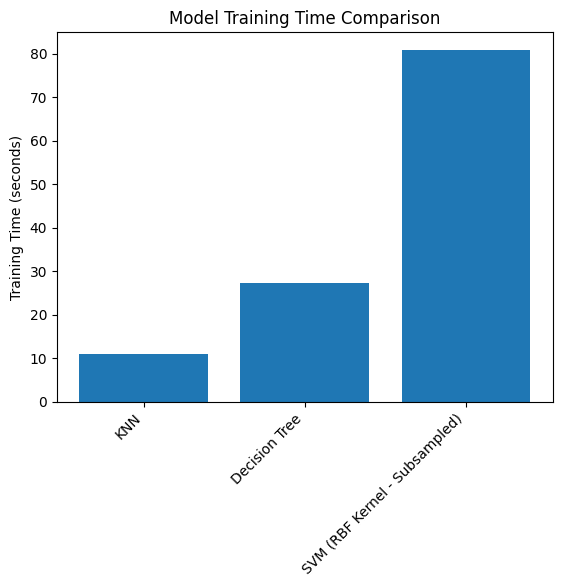

In [29]:
# Bar plot of Training Time for all models
plt.figure()
plt.bar(results_df['Model'], results_df['Train Time (s)'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Training Time (seconds)")
plt.title("Model Training Time Comparison")
plt.show()

In [ ]:
##Side-By-Side ROC Curve across all models

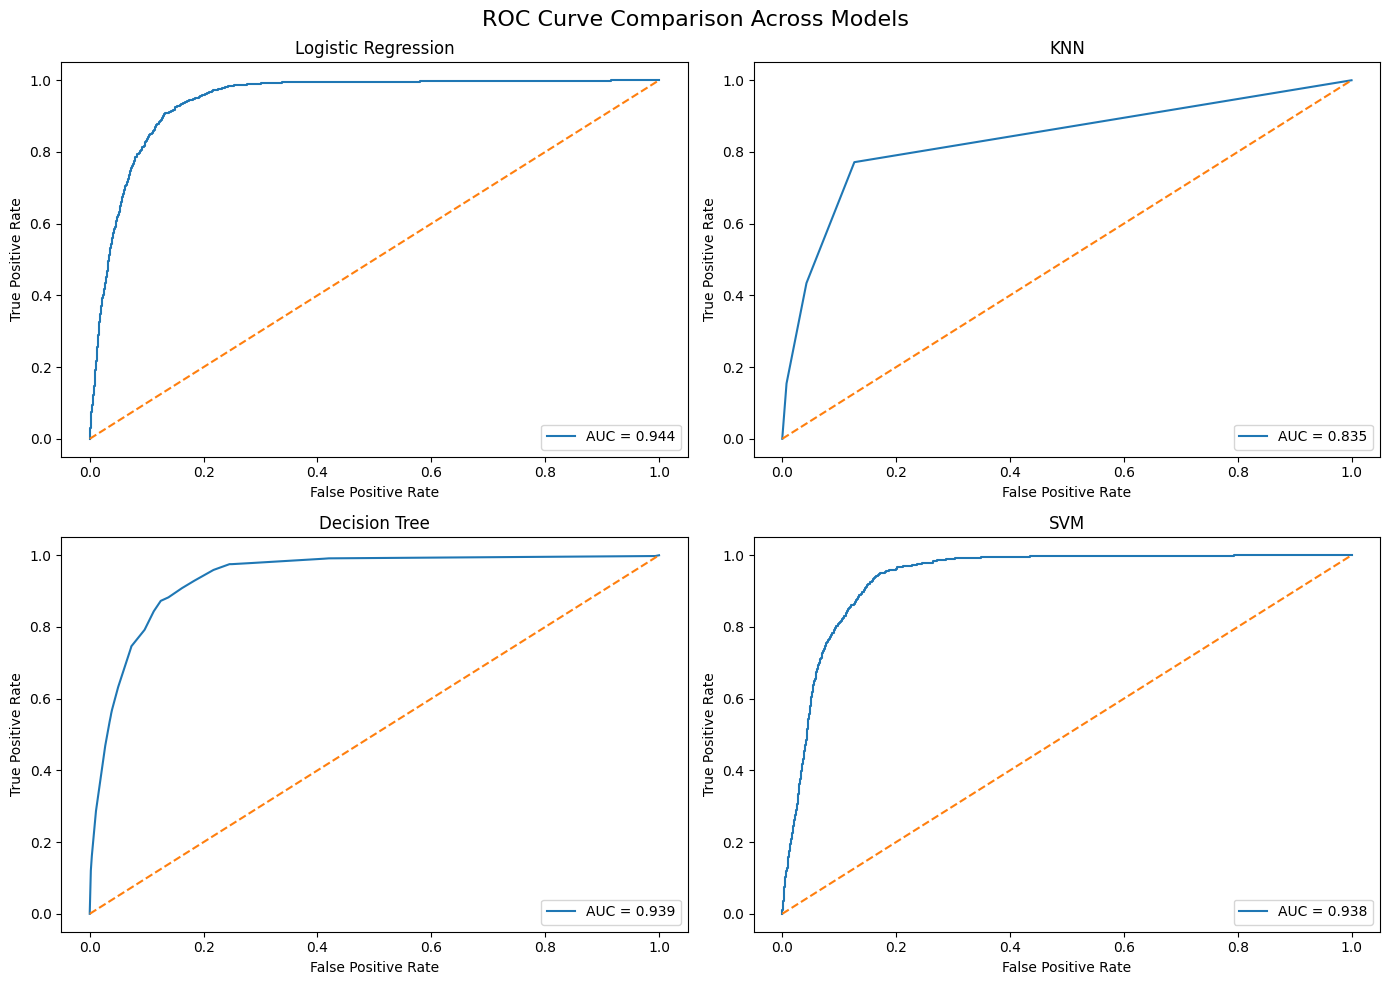

In [30]:
models = {
    'Logistic Regression': lr_proba,
    'KNN': knn_proba,
    'Decision Tree': dt_proba,
    'SVM': svm_scores
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (model_name, y_score) in zip(axes, models.items()):
    fpr, tpr, _ = roc_curve((y_test == 'yes').astype(int), y_score)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_title(model_name)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')

fig.suptitle('ROC Curve Comparison Across Models', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
##Side-By-Side Confusion Matrix across all models

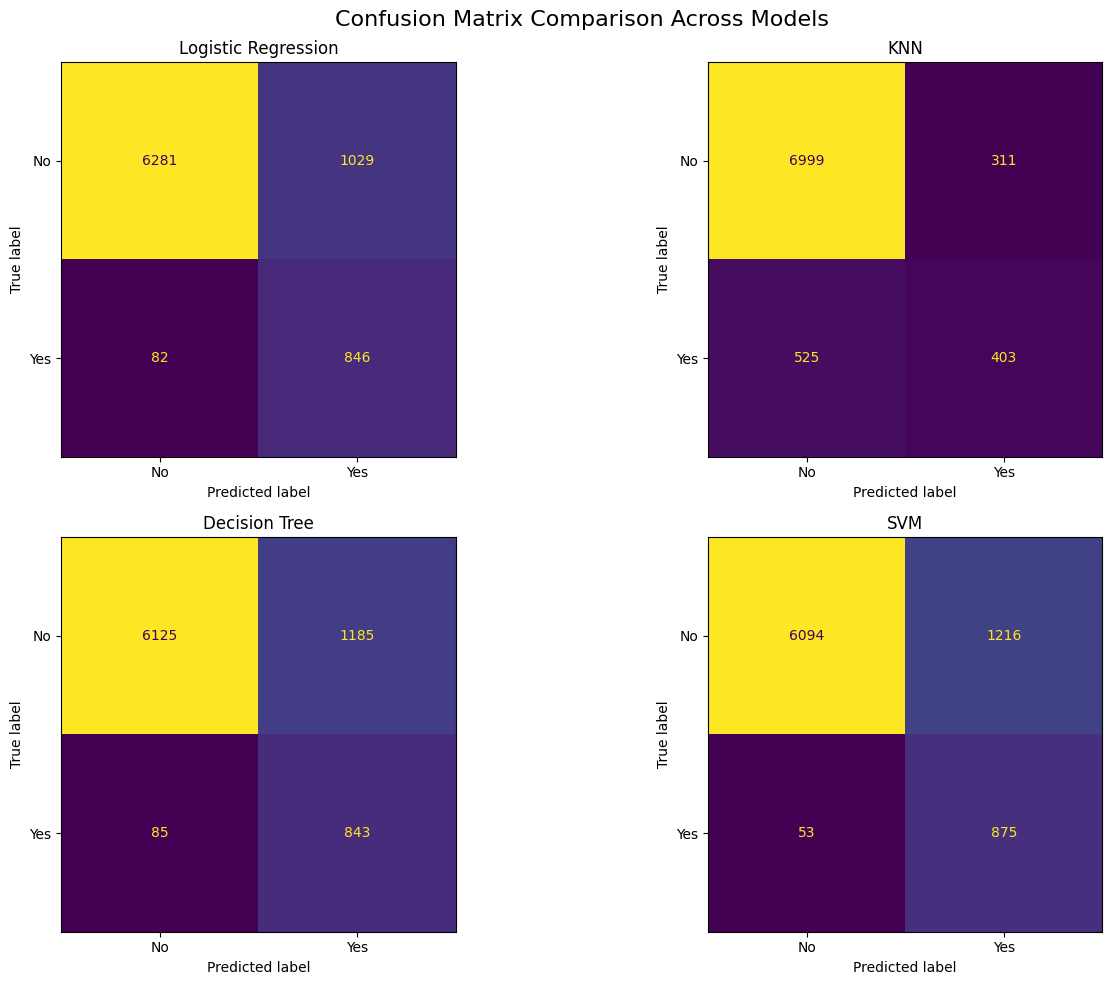

In [31]:
predictions = {
    'Logistic Regression': lr_pred,
    'KNN': knn_pred,
    'Decision Tree': dt_pred,
    'SVM': svm_pred
}
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (model_name, y_pred) in zip(axes, predictions.items()):
    cm = confusion_matrix(y_test, y_pred, labels=['no', 'yes'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(ax=ax, values_format='d', colorbar=False)
    ax.set_title(model_name)

fig.suptitle('Confusion Matrix Comparison Across Models', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
##Conclusion

1 Model-by-Model Summary


Logistic Regression (Baseline)

Highlights:
Fastest training time
Stable and interpretable
Strong baseline performance
Assumes linear decision boundary
Strength: Reliability and simplicity

Limitation: Limited ability to capture non-linearity


K-Nearest Neighbors (KNN)

Highlights:
Sensitive to feature scaling
Performance varies with k
Computational cost increases at prediction time
Strength: Non-parametric, flexible

Limitation: Noisy decision boundaries, scalability issues


Decision Tree

Highlights:
High training accuracy
Clear overfitting tendency without tuning
Highly interpretable
Strength: Explainability

Limitation: Generalization performance weaker than other models


Support Vector Machine (SVM)

Highlights:
Best generalization performance
Strong ROC-AUC and Recall
Most computationally expensive
Strength: Excellent margin-based classification

Limitation: Long training time, less interpretable

In [ ]:
2 Best Model Selection
Best Overall Model: Support Vector Machine (SVM)

Justification:

Highest or near-highest ROC-AUC
Strong recall, critical for identifying potential subscribers
Maintains balance between false positives and false negatives
Demonstrates robust generalization on unseen data

##3 Business Findings & Recommendations

Clients contacted multiple times show diminishing returns.
SVM model best identifies high-probability subscribers.
Marketing efforts should prioritize high-recall predictions.

4 Next Steps

Incorporate cost-sensitive learning

Evaluate campaign timing effects

Test model on newer campaign data

5 Final Conclusion


In this study, multiple classification models were evaluated to predict whether a client would subscribe to a term deposit. Logistic Regression provided a strong baseline with efficient training and stable performance. KNN and Decision Trees captured non-linear relationships but were sensitive to parameter choices and prone to overfitting. The Support Vector Machine achieved the strongest overall performance, demonstrating superior discriminative ability and generalization, albeit at higher computational cost. Given the business objective of accurately identifying potential subscribers, the SVM model was selected as the optimal solution.

##### Questions